In [2]:
import numpy as np
import torch
import scipy.stats as scs
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist
from pyhmc import hmc


In [3]:
import ot
def W2(x,y):
    return torch.sqrt(ot.emd2(torch.ones(x.shape[0])/x.shape[0], torch.ones(y.shape[0])/y.shape[0], ot.dist(x, y)))


c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [4]:
# load all mnist data
import torchvision.datasets as datasets
import torchvision.transforms as transforms

np.random.seed(990109)
torch.manual_seed(990109)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([transforms.ToTensor(),transforms.Lambda(lambda x: x.view(784))])
trainset = datasets.MNIST(root='.', train=True, download=False, transform=transform)
data_true = trainset.data.numpy()
data_true = data_true.reshape(data_true.shape[0], -1)

# Add Gaussian noise to dequentize
noise = scs.norm.rvs(0, 0.05, data_true.shape)
X_noisy_flat = (data_true + noise)

# Apply ECDF transformation
X_ecdf = np.zeros_like(X_noisy_flat)
ecdf_list = []
for dim in (range(X_noisy_flat.shape[1])):
    ecdf = ECDF(X_noisy_flat[:, dim])
    ecdf_list.append(ecdf)
    X_ecdf[:, dim] = np.clip(ecdf(X_noisy_flat[:, dim]), 1e-6, 1 - 1e-6)



# Apply inverse of standard normal CDF (ppf)
X_gaussian = scs.norm.ppf(X_ecdf).reshape(-1, 28,28)
y_gaussian = torch.ones(X_gaussian.shape[0], dtype=torch.long)
# make it a tensor with shape (n_samples, n_channels, height, width)
X_gaussian = torch.tensor(X_gaussian, dtype=torch.float32).unsqueeze(1)  # Add channel dimension

# Split the data into training and testing sets (50/50 split)
X_train, X_test, y_train, y_test = train_test_split(X_gaussian, y_gaussian, test_size=0.5, random_state=42)
# Create TensorDataset objects
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# Vine

In [ ]:
import pyvinecopulib as pv
import time 

In [22]:
U = scs.norm.cdf(X_train.reshape(-1,28*28))
U_test = scs.norm.cdf(X_test.reshape(-1,28*28))

In [37]:



start = time.time()
controls = pv.FitControlsVinecop(family_set=[pv.BicopFamily.tll],
                                                selection_criterion='mbic',
                                                nonparametric_method='constant', #KDE-copula
                                                nonparametric_mult=10,
                                                trunc_lvl=5,
                                                threshold=0.05, # truntrunc_lvl=5,threshold=0.05 30K mnist -> 33mins train/sample/evals
                                                num_threads = 8) # bandwidth
cop = pv.Vinecop(U, controls=controls)
print('fitted',time.time()-start)

time2 = time.time()
cop_sample = cop.simulate(25)
print('sims', time.time()-time2)

time3 = time.time()
cop_logpdf = cop.loglik(U_test)
print('-logpdf', time.time()-time3)
print(cop_logpdf/U_test.shape[0])

fitted 1914.9226682186127
sims 1.1795718669891357
-logpdf 66.98101162910461
131.0576872178868


In [28]:
import matplotlib.pyplot as plt

In [17]:
def reverse_transform(example):
    ''' 
    Reverse the transformation applied to the data using the ECDFs.
    
    input:
        example: torch.Tensor - the transformed example, of shape (1, 28, 28)

    output:
        original_example: np.array - the original example, of shape (28, 28)
    '''
    # Convert the tensor to a numpy array and remove the channel dimension
    example = example.squeeze().numpy().reshape(-1)
    
    # Apply the inverse of the standard normal CDF (ppf)
    example = scs.norm.cdf(example)
    
    # Apply the inverse ECDF transformation
    original_example = np.zeros_like(example)
    for i in range(len(example)):
        ecdf = ecdf_list[i]
        original_example[i] = np.interp(example[i], ecdf.y, ecdf.x)
    
    # Reshape back to the original image shape and denormalize
    original_example = original_example.reshape(28, 28) 
    
    return original_example

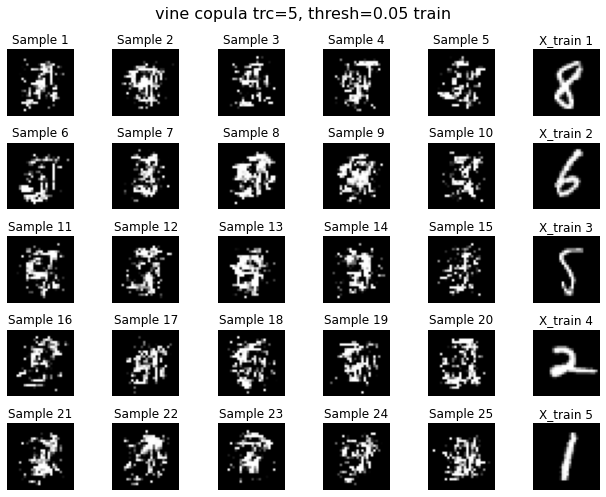

In [39]:
cop_sample_norm = scs.norm.ppf(cop_sample)

fig, axes = plt.subplots(5, 6, figsize=(9, 7))
fig.suptitle(" vine copula trc=5, thresh=0.05 train ", fontsize=16)

for i in range(5):
    for j in range(5):
        # First 5 columns: samples_100burn_19epoch
        axes[i, j].imshow(reverse_transform(torch.tensor(cop_sample_norm[i * 5 + j])).reshape(28, 28), cmap='gray')
        axes[i, j].axis('off')
        axes[i, j].set_title(f'Sample {i * 5 + j + 1}')
    
    # Last column: X_train images
    axes[i, 5].imshow(reverse_transform(X_train[i]).reshape(28, 28), cmap='gray')
    axes[i, 5].axis('off')
    axes[i, 5].set_title(f'X_train {i + 1}')

plt.tight_layout()
plt.show()

In [45]:
W2(X_test.reshape(-1,28*28).float(),torch.tensor(cop_sample_norm).reshape(-1,28*28).float())

tensor(37.5271)

# IGC

In [5]:

    #### IGC model



    class SoftRank(nn.Module):
        """Differentiable ranking layer"""
        def __init__(self, alpha=1000.0):
            super(SoftRank, self).__init__()
            self.alpha = alpha # constant for scaling the sigmoid to approximate sign function, larger values ensure better ranking, overflow is handled properly by PyTorch

        def forward(self, inputs):
            # input is a ?xSxD tensor, we wish to rank the S samples in each dimension per each batch
            # output is  ?xSxD tensor where for each dimension the entries are (rank-0.5)/N_rank
            x = inputs.unsqueeze(-1) #(?,S,D) -> (?,S,D,1)
            x_2 = x.repeat(1, 1, 1, x.shape[1]) # (?,S,D,1) -> (?,S,D,S) (samples are repeated along axis 3, i.e. the last axis)
            x_1 = x_2.transpose(1, 3) #  (?,S,D,S) -> (?,S,D,S) (samples are repeated along axis 1)
            return torch.transpose(torch.sum(torch.sigmoid(self.alpha*(x_1-x_2)), dim=1), 1, 2)/(torch.tensor(x.shape[1], dtype=torch.float32))


    class IGC(nn.Module):
        
        def __init__(self, hidden_size=100, layers_number=2, output_size=2):
            super(IGC, self).__init__()
            self.dim_latent = 3 * output_size
            self.hidden_size = hidden_size
            self.layers_nuber = layers_number
            self.output_size = output_size
            self.linear_in = nn.Linear(in_features=self.dim_latent, out_features=self.hidden_size) 
            self.linear = nn.Linear(in_features=self.hidden_size, out_features=self.hidden_size)
            self.linear_out = nn.Linear(in_features=self.hidden_size, out_features=self.output_size)
            self.marginal_cdfs = None
            self.ecdf_10e6_samples = None

        def forward_train(self, z):
            '''
            Input noise z with shape (M,dim_latent)\\
            Outputs (u,v) pairs with shape (M,output_size=2), while ensuring u and v each have uniform marginals.
            '''
            y = torch.relu(self.linear_in(z))
            for layer in range(self.layers_nuber):
                y = torch.relu(self.linear(y))
            y = self.linear_out(y).unsqueeze(0)
            u = SoftRank()(y).squeeze(0)
            return u
            
        def Energy_Score_pytorch(self,beta, observations_y, simulations_Y):
            n = len(observations_y)
            m = len(simulations_Y)

            # First part |Y-y|. Gives the L2 dist scaled by power beta. Is a vector of length n/one value per location.
            diff_Y_y = torch.pow(
                torch.norm(
                    (observations_y.unsqueeze(1) -
                    simulations_Y.unsqueeze(0)).float(),
                    dim=2,keepdim=True).reshape(-1,1),
                beta)

            # Second part |Y-Y'|. 2* because pdist counts only once.
            diff_Y_Y = 2 * torch.pow(
                nn.functional.pdist(simulations_Y),
                beta)
            Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
            return Energy


        def forward(self, n_samples):
            ''' 
            Function to sample from the copula, once training is done.

            Input: n_samples - number of samples to generate
            Output: torch.tensor of shape (n_samples, output_size) on copula space.
            '''
            with torch.no_grad():
                if self.marginal_cdfs is None:
                    self.marginal_cdfs = []
                    # sample 10^6 points from the latent space and compute empirical marginal cdfs
                    z = torch.randn(10**6, self.dim_latent)
                    y = torch.relu(self.linear_in(z))
                    for layer in range(self.layers_nuber):
                        y = torch.relu(self.linear(y))
                    y = self.linear_out(y) # samples used to approximate cdfs
                    for dim in range(y.shape[1]):
                        ecdf = ECDF(y[:, dim].numpy())
                        self.marginal_cdfs.append(ecdf)
                    self.ecdf_10e6_samples = y
                # sample the latent space and apply ecdfs
                z = torch.randn(n_samples, self.dim_latent)
                y = torch.relu(self.linear_in(z))
                for layer in range(self.layers_nuber):
                    y = torch.relu(self.linear(y))
                y = self.linear_out(y)
                for dim in range(y.shape[1]):
                    y[:, dim] = torch.tensor(self.marginal_cdfs[dim](y[:, dim].numpy()), dtype=torch.float32)
                return y



In [6]:
from tqdm import tqdm

In [7]:

    # make training data on 0-1 scale
    X_train_cop = torch.tensor(scs.norm.cdf(X_train.reshape(-1,28*28)),dtype=torch.float32).clip(1e-5,1-1e-5)
    
    # training loop
    igc_cop = IGC(hidden_size=100, layers_number=2, output_size=28*28)

    u_obs = X_train_cop

    optimizer = torch.optim.Adam(igc_cop.parameters())
    loss_hist = []

    for i in tqdm(range(501)):
        optimizer.zero_grad()
        u = igc_cop.forward_train(torch.randn((200, igc_cop.dim_latent)))
        loss = igc_cop.Energy_Score_pytorch(1, u_obs[np.random.choice(range(u_obs.shape[0]),100,replace=True)], u)
        loss.backward()
        optimizer.step()
        loss_hist.append(loss.item())
        if i % 10 == 0:
            print(loss.item())


  0%|          | 1/501 [00:00<07:20,  1.13it/s]

11.34643840789795


  2%|▏         | 11/501 [00:08<06:38,  1.23it/s]

11.374120712280273


  4%|▍         | 21/501 [00:16<06:22,  1.26it/s]

11.356172561645508


  6%|▌         | 31/501 [00:24<06:10,  1.27it/s]

11.433934211730957


  8%|▊         | 41/501 [00:32<05:58,  1.28it/s]

11.438138008117676


 10%|█         | 51/501 [00:40<05:50,  1.28it/s]

11.324923515319824


 12%|█▏        | 61/501 [00:48<05:39,  1.30it/s]

11.486373901367188


 14%|█▍        | 71/501 [00:56<05:39,  1.27it/s]

11.404862403869629


 16%|█▌        | 81/501 [01:04<05:26,  1.28it/s]

11.41370677947998


 18%|█▊        | 91/501 [01:12<05:20,  1.28it/s]

11.421707153320312


 20%|██        | 101/501 [01:19<05:12,  1.28it/s]

11.41400146484375


 22%|██▏       | 111/501 [01:27<05:05,  1.28it/s]

11.444886207580566


 24%|██▍       | 121/501 [01:35<04:58,  1.27it/s]

11.473718643188477


 26%|██▌       | 131/501 [01:43<04:56,  1.25it/s]

11.432014465332031


 28%|██▊       | 141/501 [01:51<04:41,  1.28it/s]

11.429393768310547


 30%|███       | 151/501 [01:59<04:41,  1.24it/s]

11.418009757995605


 32%|███▏      | 161/501 [02:07<04:31,  1.25it/s]

11.42911434173584


 34%|███▍      | 171/501 [02:15<04:22,  1.26it/s]

11.44542407989502


 36%|███▌      | 181/501 [02:23<04:09,  1.28it/s]

11.458025932312012


 38%|███▊      | 191/501 [02:31<04:16,  1.21it/s]

11.429823875427246


 40%|████      | 201/501 [02:39<03:57,  1.26it/s]

11.429819107055664


 42%|████▏     | 211/501 [02:47<03:51,  1.25it/s]

11.425553321838379


 44%|████▍     | 221/501 [02:55<03:45,  1.24it/s]

11.444665908813477


 46%|████▌     | 231/501 [03:03<03:47,  1.19it/s]

11.462305068969727


 48%|████▊     | 241/501 [03:11<03:27,  1.26it/s]

11.418261528015137


 50%|█████     | 251/501 [03:20<03:24,  1.22it/s]

11.312676429748535


 52%|█████▏    | 261/501 [03:28<03:14,  1.24it/s]

11.343549728393555


 54%|█████▍    | 271/501 [03:36<03:17,  1.17it/s]

11.33540153503418


 56%|█████▌    | 281/501 [03:44<02:57,  1.24it/s]

11.50475025177002


 58%|█████▊    | 291/501 [03:52<02:50,  1.23it/s]

11.395421981811523


 60%|██████    | 301/501 [04:01<02:46,  1.20it/s]

11.381453514099121


 62%|██████▏   | 311/501 [04:09<02:45,  1.15it/s]

11.436767578125


 64%|██████▍   | 321/501 [04:18<02:31,  1.19it/s]

11.391743659973145


 66%|██████▌   | 331/501 [04:26<02:16,  1.24it/s]

11.4103422164917


 68%|██████▊   | 341/501 [04:34<02:09,  1.24it/s]

11.39741325378418


 70%|███████   | 351/501 [04:42<02:06,  1.19it/s]

11.405913352966309


 72%|███████▏  | 361/501 [04:51<01:56,  1.20it/s]

11.356650352478027


 74%|███████▍  | 371/501 [04:59<01:47,  1.21it/s]

11.393331527709961


 76%|███████▌  | 381/501 [05:07<01:38,  1.22it/s]

11.460561752319336


 78%|███████▊  | 391/501 [05:16<01:33,  1.18it/s]

11.394089698791504


 80%|████████  | 401/501 [05:24<01:23,  1.20it/s]

11.391175270080566


 82%|████████▏ | 411/501 [05:32<01:14,  1.21it/s]

11.443930625915527


 84%|████████▍ | 421/501 [05:41<01:06,  1.21it/s]

11.410712242126465


 86%|████████▌ | 431/501 [05:49<01:00,  1.16it/s]

11.395676612854004


 88%|████████▊ | 441/501 [05:58<00:49,  1.20it/s]

11.328198432922363


 90%|█████████ | 451/501 [06:06<00:41,  1.19it/s]

11.45802116394043


 92%|█████████▏| 461/501 [06:15<00:34,  1.16it/s]

11.372747421264648


 94%|█████████▍| 471/501 [06:23<00:25,  1.18it/s]

11.404410362243652


 96%|█████████▌| 481/501 [06:32<00:16,  1.19it/s]

11.317416191101074


 98%|█████████▊| 491/501 [06:40<00:08,  1.19it/s]

11.405900001525879


100%|██████████| 501/501 [06:48<00:00,  1.23it/s]

11.358532905578613


In [9]:
torch.save(igc_cop.state_dict(), f'igc_cop_test.pth')


In [42]:
samples_cdf = igc_cop.forward_train(torch.randn((25, igc_cop.dim_latent)))

In [43]:
print((W2(X_test.reshape(-1,28*28).float(),torch.tensor(scs.norm.ppf(samples_cdf.detach().numpy())).float(),),'IGC'))
# 30 epochs (tensor(37.4692), 'IGC')


(tensor(36.1060), 'IGC')


C:\Users\david\AppData\Local\Temp\ipykernel_19532\2475494744.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  axes[i, j].imshow(reverse_transform(torch.tensor(samples_cdf[i * 5 + j])).reshape(28, 28), cmap='gray')


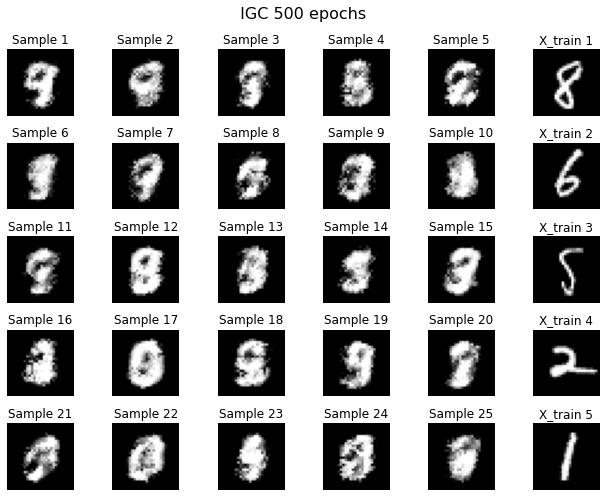

In [18]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(5, 6, figsize=(9, 7))
fig.suptitle(" IGC 500 epochs ", fontsize=16)

for i in range(5):
    for j in range(5):
        # First 5 columns: samples_100burn_19epoch
        axes[i, j].imshow(reverse_transform(torch.tensor(samples_cdf[i * 5 + j])).reshape(28, 28), cmap='gray')
        axes[i, j].axis('off')
        axes[i, j].set_title(f'Sample {i * 5 + j + 1}')
    
    # Last column: X_train images
    axes[i, 5].imshow(reverse_transform(X_train[i]).reshape(28, 28), cmap='gray')
    axes[i, 5].axis('off')
    axes[i, 5].set_title(f'X_train {i + 1}')

plt.tight_layout()
plt.show()